#데이터 탐색

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 9), reused 18 (delta 5), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [ ]:
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

Face Mask Detection.zip is done!


In [ ]:
!unzip -q Face\ Mask\ Detection.zip

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

# sorted로 img 와 annot의 짝을 맞춰준다.
img_list = sorted(glob.glob("images/*"))
annot_list = sorted(glob.glob("annotations/*"))

def generate_box(obj):
  # parser를 이용해서 xml에서 해당 값 읽어옴
  xmin = float(obj.find('xmin').text)
  ymin = float(obj.find('ymin').text)
  xmax = float(obj.find('xmax').text)
  ymax = float(obj.find('ymax').text)

  return [xmin, ymin, xmax, ymax]

def generate_label(obj):
  if obj.find("name").text == "with_mask":
    return 1
  elif obj.find("name").text == "mask_weared_incorrect":
    return 2
  else :
    return 0

def generate_target(file):
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, "html.parser")
    objects = soup.find_all("object")

    num_objs = len(objects)

    boxes = []
    labels = []

    for i in objects:
      boxes.append(generate_box(i))
      labels.append(generate_label(i))

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
        
    return target

def plot_image(img_path, annotation):
    
    img = mpimg.imread(img_path)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()


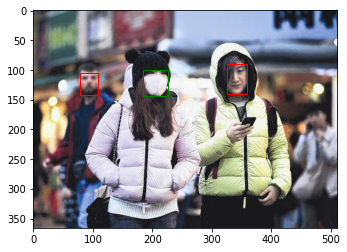

In [ ]:
bbox = generate_target(annot_list[0])
plot_image(img_list[0], bbox)

# Data Augmentation

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 102 kB 5.3 MB/s 
     |████████████████████████████████| 47.7 MB 1.5 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import torch

def generate_target(file):
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, "html.parser")
    objects = soup.find_all("object")

    num_objs = len(objects)

    boxes = []
    labels = []

    for i in objects:
      boxes.append(generate_box(i))
      labels.append(generate_label(i))


    target = {}
    target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
    target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        
    return target

def plot_image_from_output(img, annotation):
    
    img = img.permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

#Dataset 정의

In [ ]:
# ! pip list
! pip uninstall opencv-python-headless
! pip install opencv-python-headless==4.1.2.30
! pip uninstall albumentations
! pip install albumentations==0.5.2

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.62.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dist

In [ ]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

class TorchvisionMaskDataset(Dataset):
  def __init__(self, path, transform=None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform
  
  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-3] + 'xml'
    img_path = os.path.join(self.path, file_image)
    
    if 'test' in self.path:
        label_path = os.path.join("test_annotations/", file_label)
    else:
        label_path = os.path.join("annotations/", file_label)

    img = Image.open(img_path).convert("RGB")
    
    target = generate_target(label_path)
    
    # transform 에 걸리는 시간을 왜 return 하지,,?
    start_t = time.time()
    if self.transform:
        img = self.transform(img)

    total_time = (time.time() - start_t)

    return img, target, total_time #transform 한 img를 return 

In [ ]:
torchvision_transform = transforms.Compose([
  transforms.Resize((300, 300)),
  transforms.RandomCrop(224),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
  transforms.RandomHorizontalFlip(p=1),
  transforms.ToTensor(),
])

torchvision_dataset = TorchvisionMaskDataset(
    path="images/",
    transform=torchvision_transform
)

transforms 적용 전


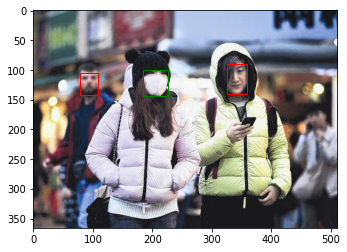

In [ ]:
only_totensor = transforms.Compose([transforms.ToTensor()])

torchvision_dataset_no_transform = TorchvisionMaskDataset(
    path = "images/",
    transform = only_totensor
)

img, annot, transform_time = torchvision_dataset_no_transform[0]
print("transforms 적용 전")
plot_image_from_output(img, annot) 

transforms 적용 후


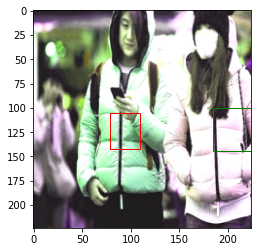

In [ ]:
img, annot, transform_time = torchvision_dataset[0]

print("transforms 적용 후")
plot_image_from_output(img, annot)
# bounding box 그대로, label 값 그대로 -> 처리 필요

In [ ]:
# __getitem__에서 실제로 transform 을 함
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time: {} ms".format(total_time*10))

torchvision time: 21.35124444961548 ms


In [ ]:
class AlbumentationsDataset(Dataset):
  def __init__(self, path, transform=None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform
  
  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-3] + 'xml'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
        label_path = os.path.join("test_annotations/", file_label)
    else:
        label_path = os.path.join("annotations/", file_label)
    
    # Read an image with OpenCV
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    target = generate_target(label_path)

    start_t = time.time()
    if self.transform:
        augmented = self.transform(image=image)
        total_time = (time.time() - start_t)
        image = augmented['image']
    
        
    return image, target, total_time

In [ ]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1), 
    albumentations.HorizontalFlip(p=1), 
    albumentations.pytorch.transforms.ToTensor()
])

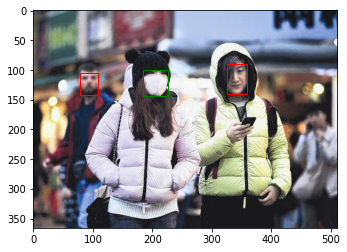

In [ ]:
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(img, annot)

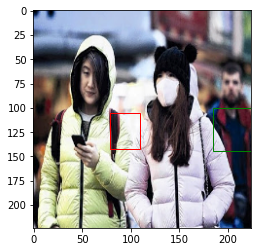

In [ ]:
albumentation_dataset = AlbumentationsDataset(
    path = "images/",
    transform = albumentations_transform
)

img, annot, transform_time = albumentation_dataset[0]
plot_image_from_output(img, annot)
# 여전히 boudning box 그대로

In [ ]:
total_time = 0
for i in range(100):
    sample, _, transform_time = albumentation_dataset[0]
    total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))
#torchvision.transform 보다 빠름

albumentations time/sample: 3.2123231887817383 ms


In [ ]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensor()
])

In [ ]:
albumentation_dataset_oneof = AlbumentationsDataset(
    path = "images/",
    transform = albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
  ax[i].axis("off")

### Bounding box Transformation

In [ ]:
class BboxAugmentationDataset(Dataset):
  def __init__(self, path, transform=None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-3] + "xml"
    img_path = os.path.join(self.path, file_image)

    if "test" in self.path:
        label_path = os.path.join("test_annotations/", file_label)
    else:
        label_path = os.path.join("annotations/", file_label)
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    target = generate_target(label_path)

    if self.transform:
      # transform에 box랑 label 을 넣어준다.
        transformed = self.transform(image = image, bboxes = target["boxes"], labels = target["labels"])
        image = transformed['image']
        target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}
    
        
    return image, target

In [ ]:
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensor()],
    bbox_params=albumentations.BboxParams(format="pascal_voc", label_fields=["labels"]),
)

In [ ]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = "images/",
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

### data split

In [ ]:
print(len(os.listdir("annotations")))
print(len(os.listdir("images")))

In [ ]:
!mkdir test_images
!mkdir test_annotations

In [ ]:
random.seed(1234)

idx = random.sample(range(853), 170)

import shutil

for img in np.array(sorted(os.listdir("images")))[idx]:
  shutil.move("images/"+img, "test_images/"+img)

for annot in np.array(sorted(os.listdir("annotations")))[idx]:
  shutil.move("annotations/"+annot, "test_annotations/"+annot)

In [ ]:
from tqdm import tqdm
import pandas as pd
from collections import Counter

def get_num_objects_for_each_class(dataset):

    total_labels = []

    for img, annot in tqdm(dataset, position = 0, leave = True):
        total_labels += [int(i) for i in annot["labels"]]

    return Counter(total_labels)


train_data =  BboxAugmentationDataset(
    path = "images/"
)

test_data =  BboxAugmentationDataset(
    path = "test_images/"
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

print("\n train 데이터에 있는 객체", train_objects)
print("\n test 데이터에 있는 객체", test_objects)